## Web Scraping and BeautifulSoup

https://www.dataquest.io/blog/web-scraping-beautifulsoup/


To source data for data science projects, you’ll often rely on SQL and NoSQL databases, APIs, or
ready-made CSV data sets.

The problem is that you can’t always find a data set on your topic, databases are not kept current
and APIs are either expensive or have usage limits.

If the data you’re looking for is on an web page, however, then the solution to all these problems is web scraping.

In this tutorial we’ll learn to scrape multiple web pages with Python using BeautifulSoup and requests.
We’ll then perform some simple analysis using pandas, and matplotlib.

You should already have some basic understanding of HTML, a good grasp of Python’s basics, and a rough
idea about what web scraping is. If you are not comfortable with these, I recommend this beginner web scraping tutorial


### Scraping data for over 2000 movies

We want to analyze the distributions of IMDB and Metacritic movie ratings to see if we find anything interesting. To do this, we’ll first scrape data for over 2000 movies.

It’s essential to identify the goal of our scraping right from the beginning. Writing a scraping script can take a lot of time, especially if we want to scrape more than one web page. We want to avoid spending hours writing a script which scrapes data we won’t actually need.

### Working out which pages to scrape

Once we’ve established our goal, we then need to identify an efficient set of pages to scrape.

We want to find a combination of pages that requires a relatively small number of requests. A request is what happens whenever we access a web page. We ‘request’ the content of a page from the server. The more requests we make, the longer our script will need to run, and the greater the strain on the server.

One way to get all the data we need is to compile a list of movie names, and use it to access the web page of each movie on both IMDB and Metacritic websites.

Since we want to get over 2000 ratings from both IMDB and Metacritic, we’ll have to make at least 4000 requests. If we make one request per second, our script will need a little over an hour to make 4000 requests. Because of this, it’s worth trying to identify more efficient ways of obtaining our data.

If we explore the IMDB website, we can discover a way to halve the number of requests. Metacritic scores are shown on the IMDB movie page, so we can scrape both ratings with a single request:

If we investigate the IMDB site further, we can discover the page shown below. It contains all the data we need for 50 movies. Given our aim, this means we’ll only have to do about 40 requests, which is 100 times less than our first option. Let’s explore this last option further.

### Identifying the URL structure

Our challenge now is to make sure we understand the logic of the URL as the pages we want to scrape change. If we can’t understand this logic enough so we can implement it into code, then we’ll reach a dead end.

If you go on IMDB’s advanced search page, you can browse movies by year:

Let’s browse by year 2017, sort the movies on the first page by number of votes, then switch to the next page. We’ll arrive at this web page, which has this URL:

In [118]:
from PIL import Image
import os
d = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\Python\Review\\12-files'
os.chdir(d)
os.getcwd()

'C:\\Users\\david\\Documents\\Programming\\Python\\Review\\12-files'

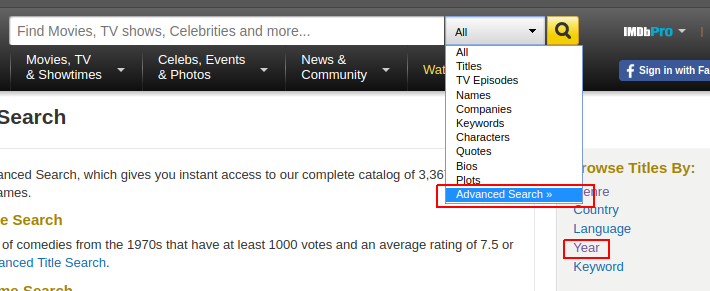

In [12]:
Image.open('pic-01.png')

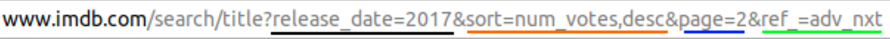

In [13]:
Image.open('pic-02.png')

In the image above, you can see that the URL has several parameters after the question mark:

    release_date — Shows only the movies released in a specific year.
    
    sort — Sorts the movies on the page. sort=num_votes,desc translates to sort by number of votes in a descending order.
    
    page — Specifies the page number.
    
    ref_ — Takes us to the the next or the previous page. The reference is the page we are currently on. adv_nxt and adv_prv  are two possible values. They translate to advance to the next page, and advance to the previous page, respectively.

If you navigate through those pages and observe the URL, you will notice that only the values of the parameters change. This means we can write a script to match the logic of the changes and make far fewer requests to scrape our data.

Let’s start writing the script by requesting the content of this single web page: http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1. In the following code cell we will:

    Import the get() function from the requests module.
    
    Assign the address of the web page to a variable named url.
    
    Request the server the content of the web page by using get(), and store the server’s response in the variable response.
    
    Print a small part of response‘s content by accessing its .text attribute (response is now a Response object).


In [14]:
from requests import get

# Assign the url to a variable
url = 'http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1'

# Get() the response object
res = get(url)

# Print out the first 500 text
print(res.text[:500])



<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///?src=mdot">



        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle",


### Understanding the HTML structure of a single page

As you can see from the first line of response.text, the server sent us an HTML document. This document describes the overall structure of that web page, along with its specific content (which is what makes that particular page unique).

All the pages we want to scrape have the same overall structure. This implies that they also have the same overall HTML structure. So, to write our script, it will suffice to understand the HTML structure of only one page. To do that, we’ll use the browser’s Developer Tools.

If you use Chrome, right-click on a web page element that interests you, and then click Inspect. This will take you right to the HTML line that corresponds to that element:

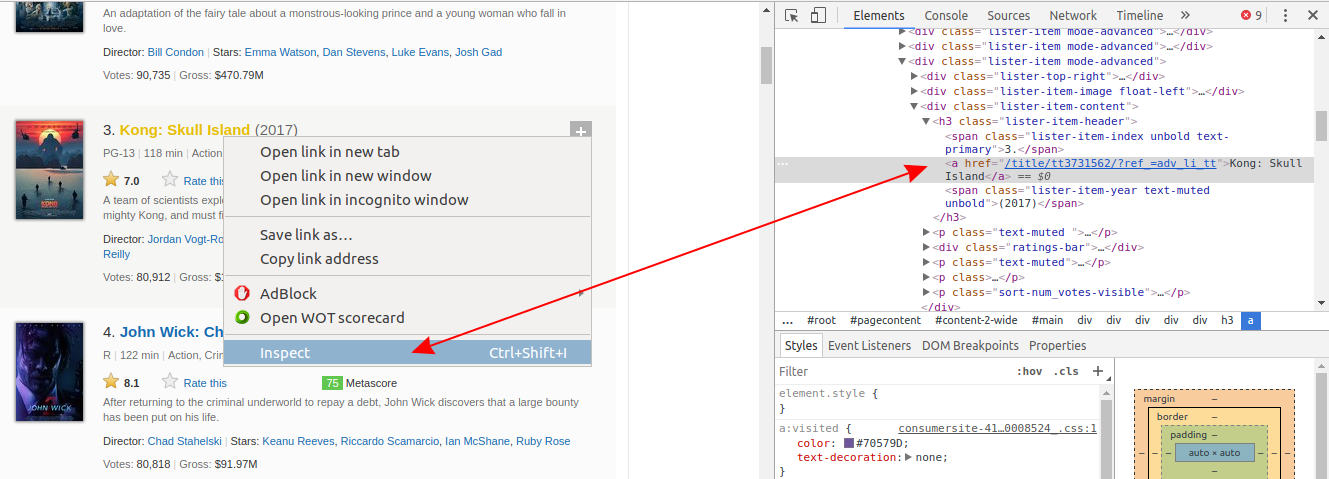

In [15]:
Image.open('pic-03.png')

 Right-click on the movie’s name, and then left-click Inspect. The HTML line highlighted in gray corresponds to what the user sees on the web page as the movie’s name.

You can also do this using both Firefox and Safari DevTools.

Notice that all of the information for each movie, including the poster, is contained in a div tag.

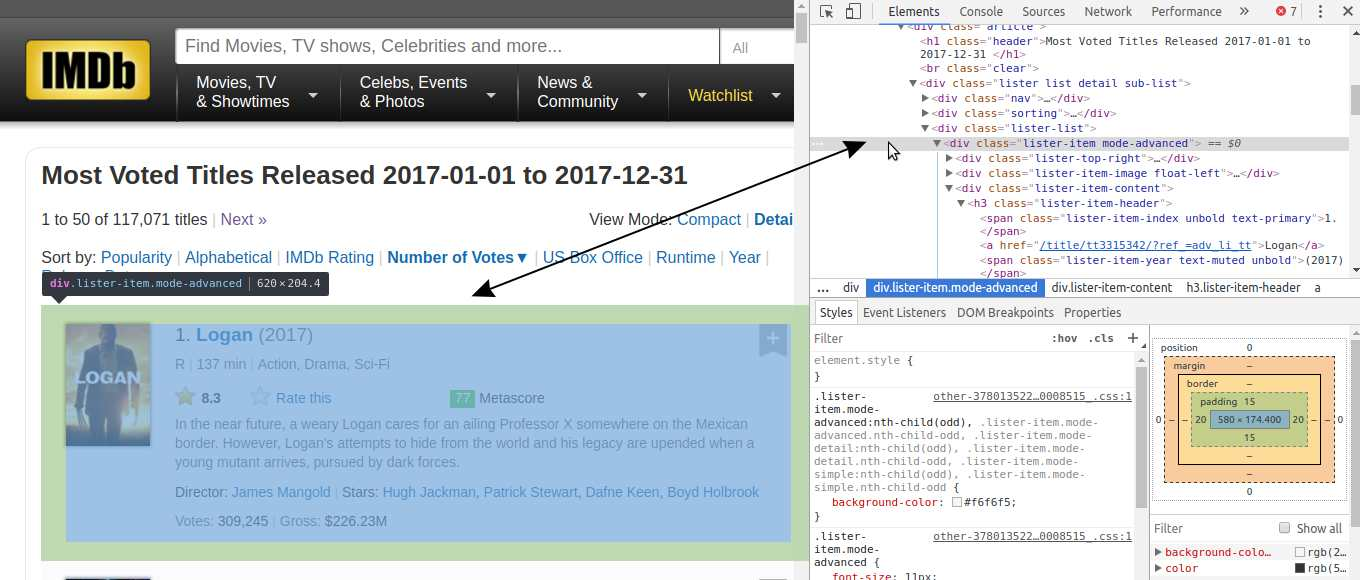

In [16]:
Image.open('pic-04.jpg')

There are a lot of HTML lines nested within each div tag. You can explore them by clicking those little gray arrows on the left of the HTML lines corresponding to each div. Within these nested tags we’ll find the information we need, like a movie’s rating.

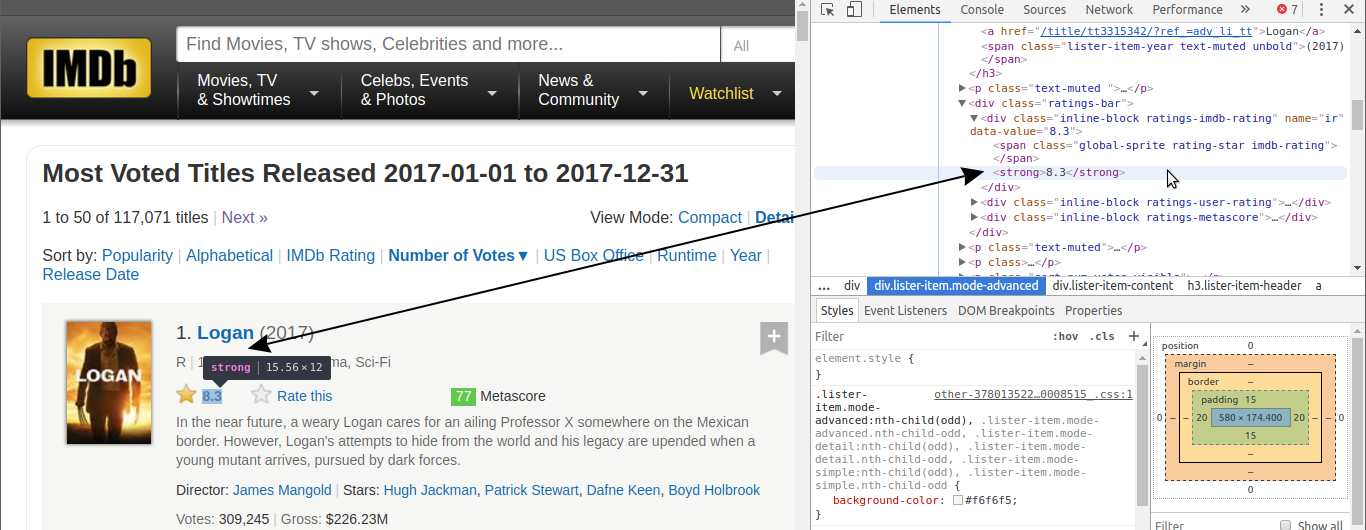

In [17]:
Image.open('pic-05.jpg')

There are 50 movies shown per page, so there should be a div container for each. Let’s extract all these 50 containers by parsing the HTML document from our earlier request.

### Using BeautifulSoup to parse the HTML content

To parse our HTML document and extract the 50 div containers, we’ll use a Python module called BeautifulSoup, the most common web scraping module for Python.

In the following code cell we will:

    Import the BeautifulSoup class creator from the package bs4.
    
    Parse response.text by creating a BeautifulSoup object, and assign this object to html_soup. The 'html.parser' argument indicates that we want to do the parsing using Python’s built-in HTML parser.


In [18]:
from requests import get
import bs4

# Assign the url to a variable
url = 'http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1'

# Get() the response object
res = get(url)

# Use BeautifulSoup()
soup = bs4.BeautifulSoup(res.text, 'html.parser')
type(soup)

bs4.BeautifulSoup

Before extracting the 50 div containers, we need to figure out what distinguishes them from other div elements on that page. Often, the distinctive mark resides in the class attribute. If you inspect the HTML lines of the containers of interest, you’ll notice that the class attribute has two values: 

    lister-item and mode-advanced

This combination is unique to these div containers. We can see that’s true by doing a quick search (Ctrl + F). We have 50 such containers, so we expect to see only 50 matches:

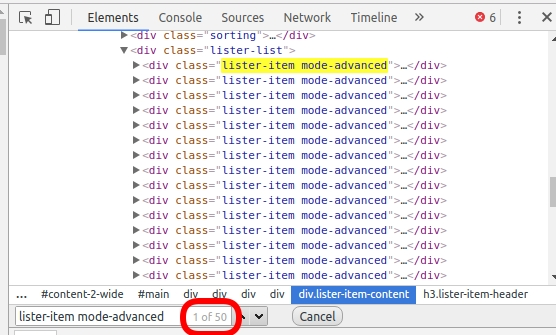

In [19]:
Image.open('pic-06.jpg')

Now let’s use the find_all() method to extract all the div containers that have a class attribute of lister-item mode-advanced:

In [20]:
movie_containers = soup.findAll('div', class_='lister-item mode-advanced')
print(type(movie_containers))
print(len(movie_containers))

<class 'bs4.element.ResultSet'>
50


find_all() returned a ResultSet object which is a list containing all the 50 divs we are interested in.

Now we’ll select only the first container, and extract, by turn, each item of interest:

    The name of the movie.
    The year of release.
    The IMDB rating.
    The Metascore.
    The number of votes.


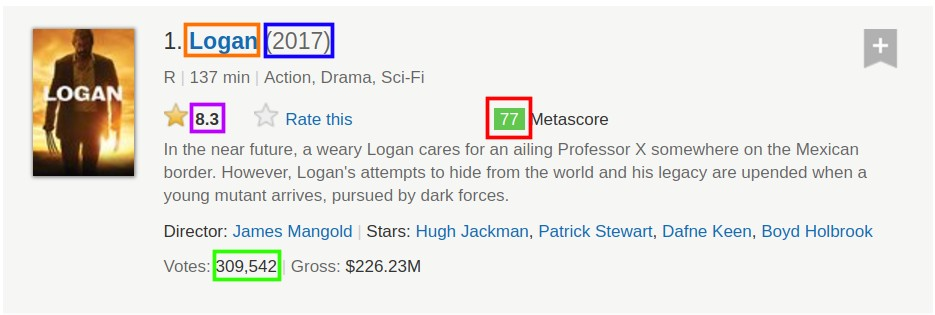

In [21]:
Image.open('pic-07.jpg')

### Extracting the data for a single movie

We can access the first container, which contains information about a single movie, by using list notation on movie_containers.

In [22]:
movie_containers[0]

<div class="lister-item mode-advanced">
<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt3315342"></div>
</div>
<div class="lister-item-image float-left">
<a href="/title/tt3315342/"> <img alt="Logan" class="loadlate" data-tconst="tt3315342" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BYzc5MTU4N2EtYTkyMi00NjdhLTg3NWEtMTY4OTEyMzJhZTAzXkEyXkFqcGdeQXVyNjc1NTYyMjg@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/G/01/imdb/images/nopicture/large/film-184890147._CB470041630_.png" width="67"/>
</a> </div>
<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt3315342/">Logan</a>
<span class="lister-item-year text-muted unbold">(2017)</span>
</h3>
<p class="text-muted">
<span class="certificate">R</span>
<span class="ghost">|</span>
<span class="runtime">137 min</span>
<span class="ghost">|</span>
<span class="genre">
Act

As you can see, the HTML content of one container is very long. To find out the HTML line specific to each data point, we’ll use DevTools once again.

### The name of the movie

We begin with the movie’s name, and locate its correspondent HTML line by using DevTools. 

You can see that the name is contained within an anchor tag (< a >). 

This tag is nested within a header tag (< h3 >). 

The < h3 > tag is nested within a  < div > tag. 

This < div > is the third of the divs nested in the container of the first movie. 

We stored the content of this container in the first_movie variable.

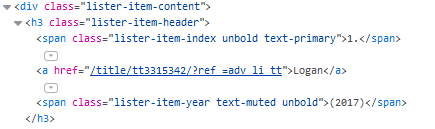

In [23]:
Image.open('pic-08.png')

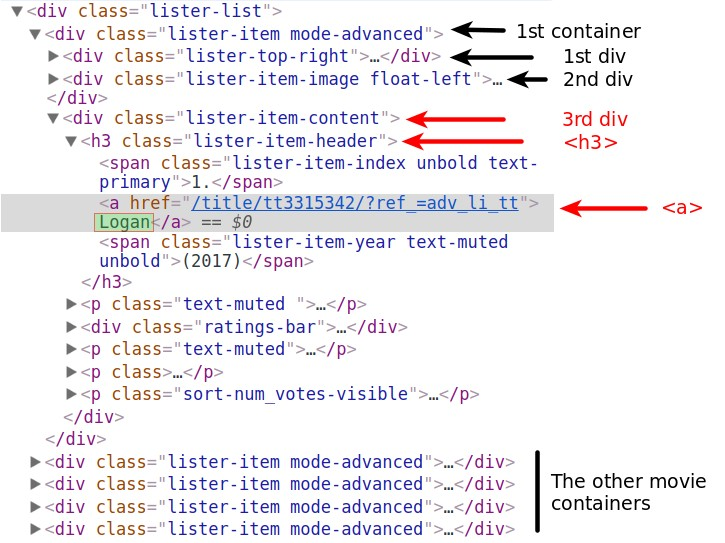

In [24]:
Image.open('pic-09.jpg')

movie_containers is a Tag object, and the various HTML tags within it are stored as its attributes. We can access them just like we would access any attribute of a Python object. However, using a tag name as an attribute will only select the first tag by that name. If we run movie_containers.div, we only get the content of the first div tag:

In [25]:
movie_containers[0].div

<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt3315342"></div>
</div>

In [26]:
movie_containers[0].a

<a href="/title/tt3315342/"> <img alt="Logan" class="loadlate" data-tconst="tt3315342" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BYzc5MTU4N2EtYTkyMi00NjdhLTg3NWEtMTY4OTEyMzJhZTAzXkEyXkFqcGdeQXVyNjc1NTYyMjg@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/G/01/imdb/images/nopicture/large/film-184890147._CB470041630_.png" width="67"/>
</a>

In [27]:
movie_containers[0].h3

<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt3315342/">Logan</a>
<span class="lister-item-year text-muted unbold">(2017)</span>
</h3>

In [28]:
movie_containers[0].h3.a

<a href="/title/tt3315342/">Logan</a>

In [29]:
movie_containers[0].h3.a.text

'Logan'

In [30]:
# Lists to store the scraped data in
Movienames = []
Movieyears = []
Movieimdb_ratings = []
Movemetascores = []
Movievotes = []
Moviecertificate = []
Movieshowtime = []
Moviegenre =[]
MovieSummary = []
pages = []
years_url =[]

for container in movie_containers:
    # If the movie has Metascore, then extract:
    if container.find('div', class_ = 'ratings-metascore') is not None:
        # The name
        name = container.h3.a.text  # Getting .h3.a.text (3 tags)
        Movienames.append((name))

print(Movienames)

['Logan', 'Wonder Woman', 'Guardians of the Galaxy Vol. 2', 'Thor: Ragnarok', 'Dunkirk', 'Star Wars: Episode VIII - The Last Jedi', 'Spider-Man: Homecoming', 'Get Out', 'Blade Runner 2049', 'Baby Driver', 'It', 'Three Billboards Outside Ebbing, Missouri', 'Justice League', 'The Shape of Water', 'John Wick: Chapter 2', 'Coco', 'Jumanji: Welcome to the Jungle', 'Beauty and the Beast', 'Kong: Skull Island', 'Kingsman: The Golden Circle', 'Pirates of the Caribbean: Dead Men Tell No Tales', 'Alien: Covenant', 'War for the Planet of the Apes', 'The Greatest Showman', 'Life', 'The Fate of the Furious', 'Murder on the Orient Express', 'Lady Bird', 'Ghost in the Shell', 'King Arthur: Legend of the Sword', 'Wind River', "The Hitman's Bodyguard", 'Mother!', 'The Mummy', 'Call Me by Your Name', 'Atomic Blonde', 'Bright', 'I, Tonya', 'Valerian and the City of a Thousand Planets', 'Baywatch', 'Darkest Hour', 'American Made', 'Transformers: The Last Knight', 'The Lego Batman Movie', 'The Disaster Art

### The year of the movie’s release

We move on with extracting the year. This data is stored within the <span> tag below the <a> that contains the name.

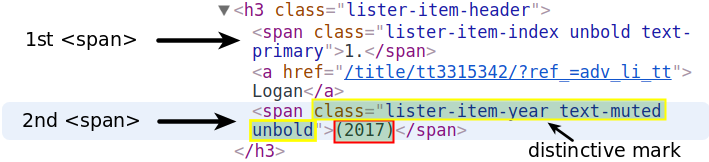

In [31]:
Image.open('pic-10.png')

Dot notation will only access the first span element. We’ll search by the distinctive mark of the second < span >. 

#### We’ll use the find() method which is almost the same as find_all(), except that it only returns the first match. In fact, find() is equivalent to find_all(limit = 1). 

The limit argument limits the output to the first match.

The distinguishing mark consists of the values lister-item-year text-muted unbold assigned to the class attribute. So we look for the first < span > with these values within the < h3 > tag:

In [32]:
# Use find() to get the movie year - find the class attribute inside the span
first_year = movie_containers[0].h3.find('span', class_='lister-item-year text-muted unbold')
print(first_year)

<span class="lister-item-year text-muted unbold">(2017)</span>


In [33]:
# Get the first_year text
first_year.text

'(2017)'

From here, we just access the text using attribute notation:

    first_year.text
    
We could easily clean that output and convert it to an integer. But if you explore more pages, you will notice that for some movies the year takes unpredictable values like (2017)(I) or (2015)(V). It’s more efficient to do the cleaning after the scraping, when we’ll know all the year values.

### The IMDB rating

We now focus on extracting the IMDB rating of the first movie.

There are a couple of ways to do that, but we’ll first try the easiest one. If you inspect the IMDB rating using DevTools, you’ll notice that the rating is contained within a < strong > tag.

In [34]:
movie_containers[0].find('div', class_='inline-block ratings-imdb-rating')

<div class="inline-block ratings-imdb-rating" data-value="8.1" name="ir">
<span class="global-sprite rating-star imdb-rating"></span>
<strong>8.1</strong>
</div>

In [35]:
movie_containers[0].strong

<strong>8.1</strong>

Great! We’ll access the text, convert it to the float type, and assign it to the variable first_imdb:

In [36]:
first_imdb = float(movie_containers[0].strong.text)

In [37]:
first_imdb

8.1

### The Metascore

If we inspect the Metascore using DevTools, we’ll notice that we can find it within a span tag.

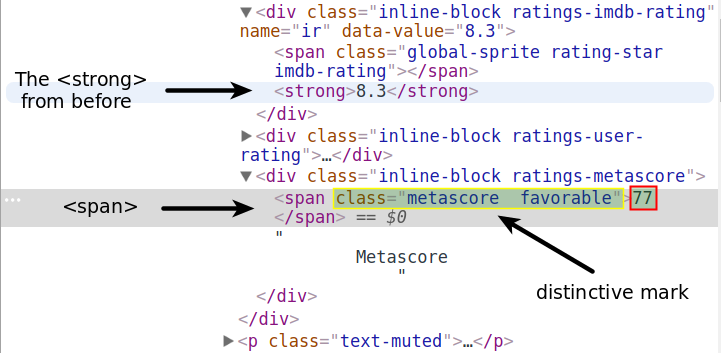

In [38]:
Image.open('pic-11.png')

In [55]:
# Attempt using .find()
movie_containers[0].find('div', class_='inline-block ratings-metascore')

<div class="inline-block ratings-metascore">
<span class="metascore favorable">77        </span>
        Metascore
            </div>

Attribute notation clearly isn’t a solution. There are many < span > tags before that. You can see one right above the < strong > tag. We’d better use the distinctive values of the class attribute (metascore favorable).

Note that if you copy-paste those values from DevTools’ tab, there will be two white space characters between metascore and favorable. Make sure there will be only one whitespace character when you pass the values as arguments to the class_ parameter. Otherwise, find() won’t find anything.

In [81]:
first_mscore = movie_containers[0].find('span', class_='metascore favorable')

In [82]:
first_mscore

<span class="metascore favorable">77        </span>

In [83]:
# Use the dot notation to get .text and transform variable to an Int
first_mscore = int(first_mscore.text)

In [84]:
first_mscore

77

The favorable value indicates a high Metascore and sets the rating’s background color to green. The other two possible values are unfavorable and mixed. What is specific to all Metascore ratings though is only the metascore value. This is the one we are going to use when we’ll write the script for the entire page.

### The number of votes

The number of votes is contained within a <span> tag. Its distinctive mark is a name attribute with the value nv.

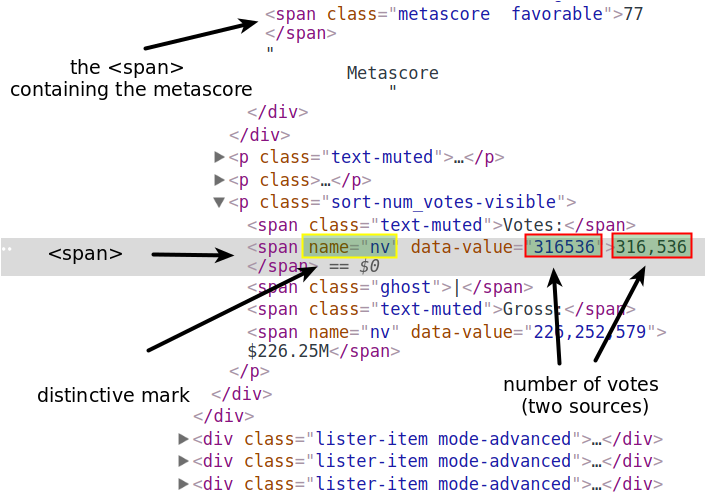

In [44]:
Image.open('pic-12.png')

The name attribute is different from the class attribute. Using BeautifulSoup we can access elements by any attribute. The find() and find_all() functions have a parameter named attrs. To this we can pass in the attributes and values we are searching for as a dictionary:

In [66]:
# Using attrs parameter, pass the attributes and values as a dictionary
first_votes = movie_containers[0].find('span', attrs = {'name':'nv'})

In [67]:
first_votes

<span data-value="556189" name="nv">556,189</span>

In [68]:
"""
Use the dot notation without .text()
Access the value through the data-type attribute instead of .text notation
This way we can convert the extracted datapoint to an int without having to strip a comma

You can treat a Tag object just like a dictionary. The HTML attributes are the dictionary’s keys.
The values of the HTML attributes are the values of the dictionary’s keys
"""

first_votes.text  # second way to pull 556,189
type(first_votes)
first_votes = first_votes['data-value']

We could use .text notation to access the <span> tag’s content. It would be better though if we accessed the value of the data-value attribute. This way we can convert the extracted datapoint to an int without having to strip a comma.

You can treat a Tag object just like a dictionary. The HTML attributes are the dictionary’s keys. The values of the HTML attributes are the values of the dictionary’s keys. This is how we can access the value of the data-value attribute:

In [69]:
first_votes = int(first_votes)

In [70]:
first_votes

556189

### The script for a single page

Before piecing together what we’ve done so far, we have to make sure that we’ll extract the data only from the containers that have a Metascore.

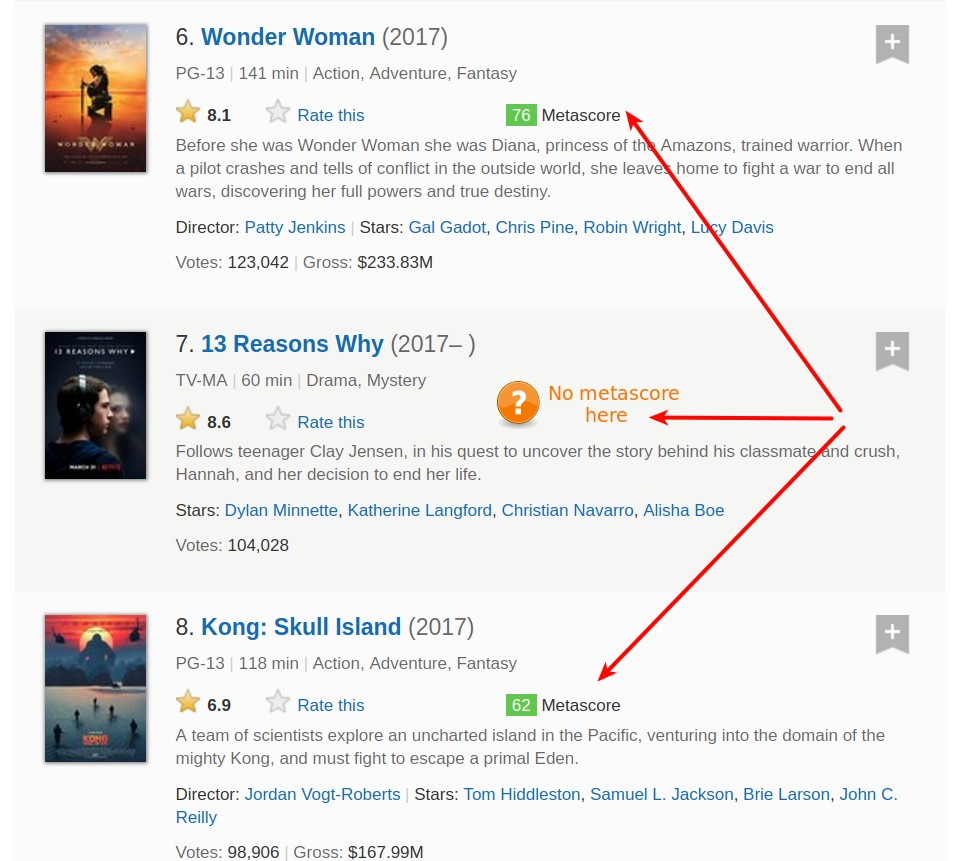

In [50]:
Image.open('pic-13.jpg')

We need to add a condition to skip movies without a Metascore.

Using DevTools again, we see that the Metascore section is contained within a <div> tag. The class attribute has two values: inline-block and ratings-metascore. The distinctive one is clearly ratings-metascore.

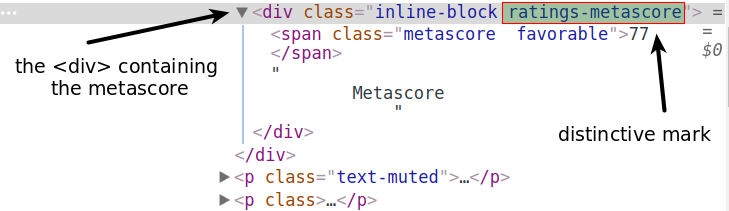

In [51]:
Image.open('pic-14.png')

We can use find() to search each movie container for a div having that distinct mark. When find() doesn’t find anything, it returns a None object. We can use this result in an if statement to control whether a movie is scraped.

Let’s look on the web page to search for a movie container that doesn’t have a Metascore, and see what find() returns.

Important: when I ran the following code, the eighth container didn’t have a Metascore. However, this is a moving target, because the number of votes constantly changes for each movie. To get the same outputs as I did in the next demonstrative code cell, you should search a container that doesn’t have a Metascore at the time you’re running the code.

In [52]:
# Use find() to get distinctive class attribute value 'ratings-metascore'
eighth_movie_mscore = movie_containers[7].find('div', class_='ratings-metascore')

In [53]:
eighth_movie_mscore

<div class="inline-block ratings-metascore">
<span class="metascore favorable">84        </span>
        Metascore
            </div>

In [54]:
type(eighth_movie_mscore)

bs4.element.Tag

Now let’s put together the code above, and compress it as much as possible, but only insofar as it’s still easily readable. In the next code block we:

    Declare some list variables to have something to store the extracted data in.
    Loop through each container in movie_containers (the variable which contains all the 50 movie containers).
    Extract the data points of interest only if the container has a Metascore.


#### Metascore skip if None

In [96]:
# Lists to store the scraped data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []

# Extract data from individual movie container
for container in movie_containers:
    # If the movie has Metascore, then extract:
    if container.find('div', class_='ratings-metascore') is not None:
        # Name
        name = container.h3.a.text
        names.append(name)
        # Year
        year = container.h3.find('span', class_='lister-item-year').text
        years.append(year)
        # IMDB Rating
        imdb = float(container.strong.text)
        imdb_ratings.append(imdb)
        # Metascore (Question: class_='metascore' vs class_'metascore favorable)
        m_score = container.find('span', class_='metascore').text
        metascores.append(int(m_score))
        # Votes
        vote = container.find('span', attrs = {'name':'nv'})['data-value']
        votes.append(vote)

In [95]:
# Error with this one because attrs vs. attr 
print(movie_containers[0].find('span', attr = {'name':'nv'}))

None


In [98]:
# Import pandas to see if data scraping was successful
import pandas as pd

# Create a dataframe to store the values
test_df = pd.DataFrame({'movie': names,
                       'years': years,
                       'imdb': imdb_ratings,
                       'metascore': metascores,
                       'votes': votes})
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 5 columns):
movie        45 non-null object
years        45 non-null object
imdb         45 non-null float64
metascore    45 non-null int64
votes        45 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ KB
None


In [99]:
test_df

,movie,years,imdb,metascore,votes
0,Logan,(2017),8.1,77,556189
1,Wonder Woman,(2017),7.5,76,485681
2,Guardians of the Galaxy Vol. 2,(2017),7.7,67,479735
3,Thor: Ragnarok,(2017),7.9,74,478557
4,Dunkirk,(2017),7.9,94,464493
5,Star Wars: Episode VIII - The Last Jedi,(2017),7.2,85,461206
6,Spider-Man: Homecoming,(2017),7.5,73,422611
7,Get Out,(I) (2017),7.7,84,397231
8,Blade Runner 2049,(2017),8.0,81,374745
9,Baby Driver,(2017),7.6,86,361118


As a side note, if you run the code from a country where English is not the main language, it’s very likely that you’ll get some of the movie names translated into the main language of that country.

Most likely, this happens because the server infers your location from your IP address. Even if you are located in a country where English is the main language, you may still get translated content. This may happen if you’re using a VPN while you’re making the GET requests.

If you run into this issue, pass the following values to the headers parameter of the get() function:

#### headers = {"Accept-Language": "en-US, en;q=0.5"}

This will communicate the server something like “I want the linguistic content in American English (en-US). If en-US is not available, then other types of English (en) would be fine too (but not as much as en-US).”. The q parameter indicates the degree to which we prefer a certain language. If not specified, then the values is set to 1 by default, like in the case of en-US. You can read more about this here.

https://www.w3.org/Protocols/rfc2616/rfc2616-sec14.html#sec14.4

### The script for multiple pages
Scraping multiple pages is a bit more challenging. We’ll build upon our one-page script by doing three more things:

Making all the requests we want from within the loop.
Controlling the loop’s rate to avoid bombarding the server with requests.
Monitoring the loop while it runs.
We’ll scrape the first 4 pages of each year in the interval 2000-2017. 4 pages for each of the 18 years makes for a total of 72 pages. Each page has 50 movies, so we’ll scrape data for 3600 movies at most. But not all the movies have a Metascore, so the number will be lower than that. Even so, we are still very likely to get data for over 2000 movies.

### Changing the URL’s parameters
As shown earlier, the URLs follow a certain logic as the web pages change.

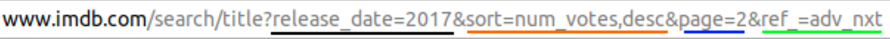

In [101]:
Image.open('pic-15.png')

As we are making the requests, we’ll only have to vary the values of only two parameters of the URL: the release_date parameter, and page. Let’s prepare the values we’ll need for the forthcoming loop. In the next code cell we will:

- Create a list called pages, and populate it with the strings corresponding to the first 4 pages.

- Create a list called years_url and populate it with the strings corresponding to the years 2000-2017.

In [103]:
# Create a list called pagess and populate it with strings corresponding to the first 4 pages
pages = [str(i) for i in range(0,5)]

# Create a list called years_url and populate it with the strings corresponding to the years 2000-2007
years_url = [str(i) for i in range(2000,2019)]

### Controlling the crawl-rate
Controlling the rate of crawling is beneficial for us, and for the website we are scraping. If we avoid hammering the server with tens of requests per second, then we are much less likely to get our IP address banned. We also avoid disrupting the activity of the website we scrape by allowing the server to respond to other users’ requests too.

We’ll control the loop’s rate by using the sleep() function from Python’s time module. sleep() will pause the execution of the loop for a specified amount of seconds.

To mimic human behavior, we’ll vary the amount of waiting time between requests by using the randint() function from the Python’s random module. randint() randomly generates integers within a specified interval.

In [108]:
# Using time - practice
from time import sleep
from random import randint
for i in range(0, 5):
    rndm = randint(1,4)
    sleep(rndm) 
    print('loop: ' + str(i) + ' - sleeping for ' + str(rndm) + ' sec')
    # Time module sleep for random seconds between 1-4
    

loop: 0 - sleeping for 1 sec
loop: 1 - sleeping for 3 sec
loop: 2 - sleeping for 2 sec
loop: 3 - sleeping for 1 sec
loop: 4 - sleeping for 4 sec


For now, let’s just import these two functions to prevent overcrowding in the code cell containing our main sleep from loop

### Monitoring the loop as it’s still going
Given that we’re scraping 72 pages, it would be nice if we could find a way to monitor the scraping process as it’s still going. This feature is definitely optional, but it can be very helpful in the testing and debugging process. Also, the greater the number of pages, the more helpful the monitoring becomes. If you are going to scrape hundreds or thousands of web pages in a single code run, I would say that this feature becomes a must.

For our script, we’ll make use of this feature, and monitor the following parameters:

- The frequency (speed) of requests, so we make sure our program is not overloading the server.
- The number of requests, so we can halt the loop in case the number of expected requests is exceeded.
- The status code of our requests, so we make sure the server is sending back the proper responses.

To get a frequency value we’ll divide the number of requests by the time elapsed since the first request. This is similar to computing the speed of a car – we divide the distance by the time taken to cover that distance. Let’s experiment with this monitoring technique at a small scale first. In the following code cell we will:
- Set a starting time using the time() function from the time module, and assign the value to start_time.
- Assign 0 to the variable requests which we’ll use to count the number of requests.
- Start a loop, and then with each iteration:
    - Simulate a request.
    - Increment the number of requests by 1.
    - Pause the loop for a time interval between 8 and 15 seconds.
    - Calculate the elapsed time since the first request, and assign the value to elapsed_time.
    - Print the number of requests and the frequency.

In [111]:
import time
import random

requests = 0
store_requests = []

# Start time
start_time = time.time()
for _ in range(5):
    requests += 1
    sleep(randint(1,3))
    elapsed_time = time.time() - start_time
    txt = 'Request: {}; Frequency: {} requests/s'.format(requests, requests/elapsed_time)
    print(txt)
    store_requests.append(txt)


Request: 1; Frequency: 0.33328756325171 requests/s
Request: 2; Frequency: 0.49980046370590314 requests/s
Request: 3; Frequency: 0.4997943691055886 requests/s
Request: 4; Frequency: 0.44425781460804264 requests/s
Request: 5; Frequency: 0.499761611686587 requests/s


Since we’re going to make 72 requests, our work will look a bit untidy as the output accumulates. To avoid that, we’ll clear the output after each iteration, and replace it with information about the most recent request. To do that we’ll use the clear_output()function from the IPython’s core.display module. We’ll set the wait parameter of clear_output() to True to wait with replacing the current output until some new output appears.

In [112]:
import time
import random
from IPython.core.display import clear_output

# Create variables
requests = 0
store_requests = []

# Start time and loop through requests
start_time = time.time()
for _ in range(5):
    requests+=1
    sleep(randint(1,3))
    elapsed_time = time.time() - start_time
    txt = 'Requests: {}, Frequency: {} requests/s'.format(requests, requests/elapsed_time)
    print(txt)
    # Store the requests since we are going to clear the output view
    store_requests.append(txt)
    # Clear previous output with new iteration for a cleaner output view
    clear_output(wait = True)

Requests: 5, Frequency: 0.5543463498449608 requests/s


To monitor the status code we’ll set the program to warn us if there’s something off. A successful request is indicated by a status code of 200. We’ll use the warn() function from the warnings module to throw a warning if the status code is not 200.

In [114]:
from warnings import warn
warn('Warning simulation')

c:\users\david\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Warning simulation
  


We chose a warning over breaking the loop because there’s a good possibility we’ll scrape enough data, even if some of the requests fail. We will only break the loop if the number of requests is greater than expected.

### Piecing everything together
Now let’s piece together everything we’ve done so far! In the following code cell, we start by:
- Redeclaring the lists variables so they become empty again.
- Preparing the monitoring of the loop.

Then, we’ll:
- Loop through the years_url list to vary the release_date parameter of the URL.
- For each element in years_url, loop through the pages list to vary the page parameter of the URL.
- Make the GET requests within the pages loop (and give the headers parameter the right value to make sure we get only English content).
- Pause the loop for a time interval between 8 and 15 seconds.
- Monitor each request as discussed before.
- Throw a warning for non-200 status codes.
- Break the loop if the number of requests is greater than expected.
- Convert the response‘s HTML content to a BeautifulSoup object.
- Extract all movie containers from this BeautifulSoup object.
- Loop through all these containers.
- Extract the data if a container has a Metascore.

In [121]:
from requests import get
import bs4
from PIL import Image
import os
import time
import random
from IPython.core.display import clear_output
from warnings import warn
import pandas as pd

warn('Warning simulation')

# Create a list called pagess and populate it with strings corresponding to the first 4 pages
pages = [str(i) for i in range(0,5)]

# Create a list called years_url and populate it with the strings corresponding to the years 2000-2007
years_url = [str(i) for i in range(2015,2019)]

# Get english version if available for non-english websites
headers = {"Accept-Language": "en-US, en;q=0.5"}

# Redeclare the lists to store the data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []

# Prepare the monitoring of the loop
start_time = time.time()
requests = 0
store_requests = []

# For every year, every page, request URL
for year_url in years_url:
    for page in pages:
        res = get('http://www.imdb.com/search/title?release_date=' + year_url + '&sort=num_votes,desc&page=' + page, headers = headers)
        # Pause the loop
        sleep(random.randint(8, 15))
        # Monitor the requests
        requests+=1
        elapsed_time = time.time() - start_time
        txt = 'Requests: {}, Frequency: {} requests/s'.format(requests, requests/elapsed_time)
        print(txt)
        # Store the requests since we are going to clear the output view
        store_requests.append(txt)
        # Clear the output
        clear_output(wait=True)
        # Throw a warning for non-200 status codes
        if res.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, res.status_code))
        if requests > 72:
            warn('Number of requests were greater than expected.')
            break
        # Parse the content of the request with BeautifulSoup
        soup = bs4.BeautifulSoup(res.text, 'html.parser')
        mv_containers = soup.find_all('div', class_='lister-item mode-advanced')
        # For every movie of these 50 per page
        for container in mv_containers:
            # Metascore
            if container.find('div', class_='ratings-metascore') is not None:
                # Scrape the name
                name = container.h3.a.text
                names.append(name)
                # Scrape the year
                year = container.h3.find('span', class_='lister-item-year').text
                years.append(year)
                # Scrape the IMDB Rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)
                # Scrape the Metascore
                m_score = container.find('span', class_='metascore').text
                metascores.append(int(m_score))
                # Scrape the votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(vote)
                
# Create a dataframe to store the values
full_df = pd.DataFrame({'movie': names,
                       'years': years,
                       'imdb': imdb_ratings,
                       'metascore': metascores,
                       'votes': votes})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 5 columns):
movie        915 non-null object
years        915 non-null object
imdb         915 non-null float64
metascore    915 non-null int64
votes        915 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 35.8+ KB
None


### Examining the scraped data
In the next code block we:

- Merge the data into a pandas DataFrame.
- Print some informations about the newly created DataFrame.
- Show the first 10 entries.

In [122]:
print(full_df.info())
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 5 columns):
movie        915 non-null object
years        915 non-null object
imdb         915 non-null float64
metascore    915 non-null int64
votes        915 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 35.8+ KB
None


,movie,years,imdb,metascore,votes
0,Star Wars: Episode VII - The Force Awakens,(2015),8.0,81,783376
1,Mad Max: Fury Road,(2015),8.1,90,778677
2,The Martian,(2015),8.0,80,678011
3,Avengers: Age of Ultron,(2015),7.3,66,662499
4,The Revenant,(2015),8.0,76,619080


The output of info() shows we collected data for well over 900 movies. We can also see that there are no null values in our dataset whatsoever.

I have checked the ratings of these first 5 movies against the IMDB’s website. They were all correct. You may want to do the same thing yourself.

We can safely proceed with cleaning the data.

### Cleaning the scraped data
We’ll clean the scraped data with two goals in mind: plotting the distribution of IMDB and Metascore ratings, and sharing the dataset. Consequently, our data cleaning will consist of:

- Reordering the columns.
- Cleaning the year column and convert the values to integers.
- Checking the extreme rating values to determine if all the ratings are within the expected intervals.
- Normalizing one of the ratings type (or both) for generating a comparative histogram.

In [125]:
# Let's start by reodering the columns
full_df = full_df[['movie', 'years', 'imdb', 'metascore', 'votes']]
full_df.head()

,movie,years,imdb,metascore,votes
0,Star Wars: Episode VII - The Force Awakens,(2015),8.0,81,783376
1,Mad Max: Fury Road,(2015),8.1,90,778677
2,The Martian,(2015),8.0,80,678011
3,Avengers: Age of Ultron,(2015),7.3,66,662499
4,The Revenant,(2015),8.0,76,619080


Now let’s convert all the values in the year column to integers.

Right now all the values are of the object type. To avoid ValueErrors upon conversion, we want the values to be composed only from numbers from 0 to 9.

Let’s examine the unique values of the year column. This helps us to get an idea of what we could do to make the conversions we want

In [126]:
# To see all the unique values, we’ll use the unique() method
full_df['years'].unique()

array(['(2015)', '(I) (2015)', '(II) (2015)', '(2016)', '(II) (2016)',
       '(I) (2016)', '(IX) (2016)', '(2017)', '(I) (2017)', '(2018)',
       '(I) (2018)', '(III) (2018)'], dtype=object)

Counting from the end toward beginning, we can see that the years are always located from the fifth character to the second. We’ll use the .str() method to select only that interval. 

#### DataFrame.loc[] method is a method that takes only index labels and returns row or dataframe if the index label exists in the caller data frame

In [127]:
# We’ll also convert the result to an integer using the astype() method
full_df.loc[:, 'years'] = full_df['years'].str[-5:-1].astype(int)

0            (2015)
1            (2015)
2            (2015)
3            (2015)
4            (2015)
5            (2015)
6        (I) (2015)
7            (2015)
8            (2015)
9        (I) (2015)
10       (I) (2015)
11           (2015)
12           (2015)
13       (I) (2015)
14           (2015)
15           (2015)
16           (2015)
17           (2015)
18           (2015)
19           (2015)
20           (2015)
21           (2015)
22           (2015)
23           (2015)
24           (2015)
25           (2015)
26           (2015)
27           (2015)
28           (2015)
29      (II) (2015)
           ...     
885          (2018)
886          (2018)
887      (I) (2018)
888          (2018)
889          (2018)
890          (2018)
891          (2018)
892          (2018)
893          (2018)
894          (2018)
895          (2018)
896          (2018)
897          (2018)
898          (2018)
899          (2018)
900          (2018)
901    (III) (2018)
902          (2018)
903          (2018)


In [128]:
# Second part
full_df['years'].str[-5:-1].astype(int)

0      2015
1      2015
2      2015
3      2015
4      2015
5      2015
6      2015
7      2015
8      2015
9      2015
10     2015
11     2015
12     2015
13     2015
14     2015
15     2015
16     2015
17     2015
18     2015
19     2015
20     2015
21     2015
22     2015
23     2015
24     2015
25     2015
26     2015
27     2015
28     2015
29     2015
       ... 
885    2018
886    2018
887    2018
888    2018
889    2018
890    2018
891    2018
892    2018
893    2018
894    2018
895    2018
896    2018
897    2018
898    2018
899    2018
900    2018
901    2018
902    2018
903    2018
904    2018
905    2018
906    2018
907    2018
908    2018
909    2018
910    2018
911    2018
912    2018
913    2018
914    2018
Name: years, Length: 915, dtype: int32

In [129]:
# We’ll also convert the result to an integer using the astype() method
# Left side gets all years, right side formats the years
full_df.loc[:, 'years'] = full_df['years'].str[-5:-1].astype(int)

In [131]:
# Visualize the first 3 values of the year column for a quick check
# See the type of the values on the last line of the output
full_df['years'].head(4)

0    2015
1    2015
2    2015
3    2015
Name: years, dtype: int32

Now we’ll check the minimum and maximum values of each type of rating. We can do this very quickly by using pandas’ describe() method. When applied on a DataFrame, this method returns various descriptive statistics for each numerical column of the DataFrame. In the next line of code we select only those rows that describe the minimum and maximum values, and only those columns which describe IMDB ratings and Metascores.

In [132]:
# Use pandas describe() method to get min max values
full_df.describe()

,years,imdb,metascore
count,915.000000,915.000000,915.000000
mean,2016.519126,7.066120,64.650273
std,1.116034,0.776818,16.600206
min,2015.000000,4.100000,27.000000
25%,2016.000000,6.600000,51.000000
50%,2017.000000,7.200000,66.000000
75%,2018.000000,7.600000,77.000000
max,2018.000000,8.500000,99.000000


In [133]:
# Use pandas describe() method to get min max values
full_df.describe().loc

In [137]:
# Use pandas describe() method to get min max values
# DataFrame.loc[] method is a method that takes only index labels and returns 
# row or dataframe if the index label exists in the caller data frame
full_df.describe().loc[['min', 'max', 'mean'], ['imdb', 'metascore']]

,imdb,metascore
min,4.10000,27.000000
max,8.50000,99.000000
mean,7.06612,64.650273


In [142]:
'dplyr'[0:2]

'dp'